# CS 178 Exploration

In [3]:
%pip install kagglehub pandas matplotlib -U --quiet
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

Note: you may need to restart the kernel to use updated packages.


In [16]:
seed = 178
adult_data = pd.read_csv('data/adult.data', header=None)

## Need to import cols, as they are not pre-defined
adult_data.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']
adult_data = adult_data.replace(' ?', pd.NA) ## Original stored nas as ' ?'

adult_data['income'] = adult_data['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0) # Label Classifier

# Get factors, label vector
X = adult_data.drop(columns=['income'])
y = adult_data['income']
X = pd.get_dummies(X, drop_first=True)
y = pd.get_dummies(y, drop_first=True).iloc[:, 0]

n_features = X.shape[1]
print(adult_data.shape)

(32561, 15)


In [5]:
# print(adult_data.describe())

# Convert non-numeric columns to categorical features and print levels and labels
for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].astype('category')
    print(f"Column: {col}")
    categories = X[col].cat.categories
    codes = X[col].cat.codes
    sorted_codes = sorted(codes.unique())
    print("Categories and Codes in ascending order by code:")
    for code in sorted_codes:
        print(f"Code: {code}, Category: {categories[code]}")
    print("\n")

for col in X.select_dtypes(include=['number']).columns:
    var = np.var(X[col])
    mean = np.mean(X[col])
    print(f"Column: {col}")
    print(f"Variance: \t {var:.6}\t Mean: \t {mean:.6}")

# Get pi = P(Y = 1)
print(f"Proportion of > 50K Income: {np.mean(y):.6}")

# Compute the F-value and p-value for each feature, toward factor analysis
f_values, p_values = f_classif(X.apply(lambda col: col.cat.codes if col.dtype.name == 'category' else col), y)
f_scores = pd.DataFrame({'Feature': X.columns, 'F-Score': f_values, 'p-Value': p_values})
f_scores = f_scores.sort_values(by=['F-Score', 'p-Value'], ascending=False)

print(f_scores)

Column: age
Variance: 	 186.056	 Mean: 	 38.5816
Column: fnlwgt
Variance: 	 1.11405e+10	 Mean: 	 1.89778e+05
Column: education_num
Variance: 	 6.61869	 Mean: 	 10.0807
Column: capital_gain
Variance: 	 5.45409e+07	 Mean: 	 1077.65
Column: capital_loss
Variance: 	 1.62372e+05	 Mean: 	 87.3038
Column: hours_per_week
Variance: 	 152.454	 Mean: 	 40.4375
Proportion of > 50K Income: 0.24081
                               Feature      F-Score   p-Value
29  marital_status_ Married-civ-spouse  8025.842062  0.000000
2                        education_num  4120.095780  0.000000
31       marital_status_ Never-married  3674.200147  0.000000
0                                  age  1886.707314  0.000000
5                       hours_per_week  1813.386282  0.000000
..                                 ...          ...       ...
60                native_country_ Cuba     0.260277  0.609934
67              native_country_ Greece     0.195063  0.658739
76             native_country_ Ireland     0.138552  0

In [6]:
## Modelling Data Prepping
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

## Logistic Regression Model

In [ ]:
## Initialize
try:
    # logit_model = LogisticRegression(max_iter=1) # Accuracy: 0.7608
    logit_model = LogisticRegression(max_iter=2000) # Accuracy: 0.8497
except ConvergenceWarning:
    print('Model Converged')

## Fit
logit_model.fit(X_train, y_train)

feature_names = ['Intercept'] + X_train.columns.tolist()
coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': [logit_model.intercept_[0]] + logit_model.coef_[0].tolist()
})

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [8]:
## Logistic Regression Results
t_accuracy = logit_model.score(X_train, y_train)
print(f"Train Accuracy: {t_accuracy:.4f}")
e_accuracy = logit_model.score(X_test, y_test)
print(f"Eval Accuracy: {e_accuracy:.4f}")


Train Accuracy: 0.8431
Eval Accuracy: 0.8497


## Simple NN

In [9]:
# Define and initialize
model = MLPClassifier(hidden_layer_sizes=(n_features, n_features), activation='logistic', solver='adam', max_iter=50, random_state=seed)

# Fit
model.fit(X_train, y_train)

# Evaluate
# Evaluate
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.7628
Test Accuracy: 0.7651


White-box approaches look more accurate - This feature set has well labeled and ordinal factors, so this makes sense. Lets try some additional models.

In [10]:
# Initialize the Random Forest model
#rf_model = RandomForestClassifier(n_estimators=20, random_state=seed) #Random Forest Test Accuracy: 0.8494
rf_model = RandomForestClassifier(n_estimators=20, random_state=seed)

# Train the model
rf_model.fit(X_train, y_train)

# Evaluate the model
rf_train_accuracy = rf_model.score(X_train, y_train)
rf_test_accuracy = rf_model.score(X_test, y_test)
print(f"Random Forest Train Accuracy: {rf_train_accuracy:.4f}")
print(f"Random Forest Test Accuracy: {rf_test_accuracy:.4f}")

Random Forest Train Accuracy: 0.9956
Random Forest Test Accuracy: 0.8494


In [11]:
# Initialize the KNN model with k neighbors
k = 5
knn_model = KNeighborsClassifier(n_neighbors=k)

# Train the model
knn_model.fit(X_train, y_train)

# Evaluate the model
# Evaluate the model
knn_train_accuracy = knn_model.score(X_train, y_train)
knn_test_accuracy = knn_model.score(X_test, y_test)
print(f"KNN Train Accuracy: {knn_train_accuracy:.4f}")
print(f"KNN Test Accuracy: {knn_test_accuracy:.4f}")

KNN Train Accuracy: 0.8345
KNN Test Accuracy: 0.7777


## Deeper dive into Random Forests

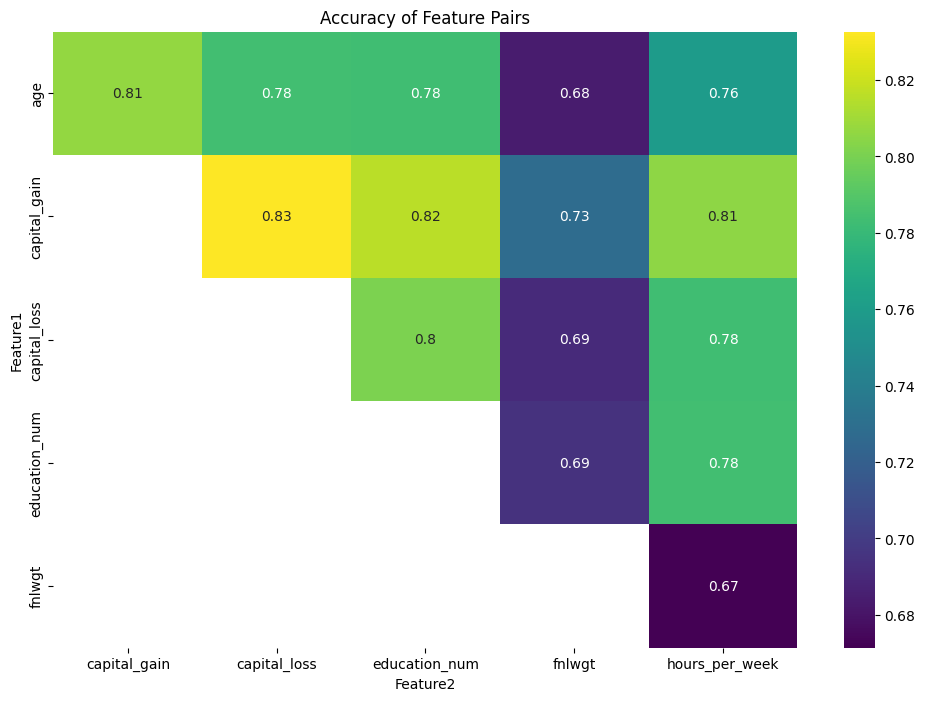

In [12]:
feature_pairs = list(combinations(X_train.select_dtypes(include=[np.number]).columns, 2))
# feature_pairs = list(combinations(X_train.columns, 2))


accuracies = []

# Iterate over each pair of features
for pair in feature_pairs:
    # Subset of X_train with the current pair of features
    X_train_subset = X_train[list(pair)]
    
    # Initialize and train the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=1, random_state=seed)
    rf_model.fit(X_train_subset, y_train)
    
    # Evaluate the model
    X_test_subset = X_test[list(pair)]
    rf_accuracy = rf_model.score(X_test_subset, y_test)
    
    # Store the accuracy
    accuracies.append((pair, rf_accuracy))

# Plot the accuracies
# Convert accuracies to a DataFrame for easier plotting
accuracy_df = pd.DataFrame(accuracies, columns=['Feature Pair', 'Accuracy'])

# Split the 'Feature Pair' column into two separate columns
# Split the 'Feature Pair' column into two separate columns and sort them
accuracy_df[['Feature1', 'Feature2']] = pd.DataFrame(accuracy_df['Feature Pair'].tolist(), index=accuracy_df.index)
accuracy_df[['Feature1', 'Feature2']] = np.sort(accuracy_df[['Feature1', 'Feature2']], axis=1)

# Pivot the table for heatmap
pivot_table = accuracy_df.pivot(index='Feature1', columns='Feature2', values='Accuracy')

# Plot the accuracies
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap='viridis', cbar=True)
plt.title('Accuracy of Feature Pairs')
plt.xlabel('Feature2')
plt.ylabel('Feature1')
plt.show()

In [13]:
from sklearn.ensemble import ExtraTreesClassifier

et_model = ExtraTreesClassifier(n_estimators=100, random_state=seed)

et_model.fit(X_train, y_train)

et_train_accuracy = et_model.score(X_train, y_train)
et_test_accuracy = et_model.score(X_test, y_test)

print(f"Extra Trees Train Accuracy: {et_train_accuracy:.4f}")
print(f"Extra Trees Test Accuracy: {et_test_accuracy:.4f}")

Extra Trees Train Accuracy: 1.0000
Extra Trees Test Accuracy: 0.8346


In [15]:
# from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

# Initialize the HistGradientBoostingClassifier model
hgb_model = HistGradientBoostingClassifier(random_state=seed,
                                           loss='log_loss',
                                           learning_rate=.1,
                                           l2_regularization=0
                                           ,early_stopping=False)

# Train the model
hgb_model.fit(X_train, y_train)

# Evaluate the model
hgb_train_accuracy = hgb_model.score(X_train, y_train)
hgb_test_accuracy = hgb_model.score(X_test, y_test)
print(f"HistGradientBoostingClassifier Train Accuracy: {hgb_train_accuracy:.4f}")
print(f"HistGradientBoostingClassifier Test Accuracy: {hgb_test_accuracy:.4f}")

HistGradientBoostingClassifier Train Accuracy: 0.8882
HistGradientBoostingClassifier Test Accuracy: 0.8712
